# Практический ноутбук: ANOVA, корреляция и регрессия

На синтетическом наборе данных рассмотрим следующие кейсы:
1. Однофакторный анализ ANOVA  
2. Корреляционный анализ
3. Регрессионный анализ

## 0. Описание данных

Нам предоставили набор данных на 180 наблюдений (студентов), со следующими столбцами:

- `student_id` — идентификатор студента  
- `group` — метод обучения (A, B, C) — для ANOVA  
- `study_hours` — часы самостоятельной подготовки (непрерывный признак)  
- `attendance` — посещаемость в процентах  
- `age` — возраст  
- `gender` — пол (M/F)  
- `midterm_score` — промежуточный тест (0-100)  
- `final_score` — итоговый тест (0-100), будем предсказывать/анализировать  
- `motivation` — самооценка мотивации (1-5)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr, spearmanr

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import patsy

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## 1. Быстрое знакомство (EDA)

Посмотрим базовую информацию о данных, описательные статистики и распределения.

In [2]:
df = pd.read_csv('students_scores.csv')
print(df.shape)
df.head()

(180, 9)


,student_id,group,study_hours,attendance,age,gender,motivation,midterm_score,final_score
0,1,B,6.43,91.2,19,F,1,74.6,77.3
1,2,C,6.36,82.9,29,F,2,77.2,85.9
2,3,C,8.63,97.1,18,M,2,97.6,100.0
3,4,B,5.54,81.1,24,F,1,63.8,87.1
4,5,A,6.95,88.6,24,M,3,84.5,89.7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   student_id     180 non-null    int64  
 1   group          180 non-null    object 
 2   study_hours    180 non-null    float64
 3   attendance     180 non-null    float64
 4   age            180 non-null    int64  
 5   gender         180 non-null    object 
 6   motivation     180 non-null    int64  
 7   midterm_score  180 non-null    float64
 8   final_score    180 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 12.8+ KB


In [4]:
df.describe()

,student_id,study_hours,attendance,age,motivation,midterm_score,final_score
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,90.500000,7.236056,88.143333,23.627778,2.038889,80.951111,90.119444
std,52.105662,2.088562,9.865708,3.607922,0.899186,11.828734,10.258416
min,1.000000,0.520000,45.500000,18.000000,1.000000,43.000000,57.100000
25%,45.750000,5.687500,81.600000,21.000000,1.000000,73.050000,83.675000
50%,90.500000,7.215000,88.650000,23.500000,2.000000,81.300000,91.750000
75%,135.250000,8.615000,97.125000,27.000000,3.000000,89.650000,100.000000
max,180.000000,14.710000,100.000000,30.000000,4.000000,100.000000,100.000000


In [5]:
df.describe(include='object')

,group,gender
count,180,180
unique,3,2
top,A,F
freq,73,108


## 2. Однофакторный анализ ANOVA

**Задача:** Провести однофакторный ANOVA для `final_score` по факторам `group`.  
- Покажите средние по группам и визуализацию (boxplot).  
- Проверьте, есть ли статистически значимые различия между группами (α = 0.05).  
- Если различия есть, выполните пост‑hoc тест (Tukey HSD) и интерпретируйте результаты.

In [6]:
# Средние по группам
group_means = df.groupby('group')['final_score'].agg(['mean','std','count'])
group_means

,mean,std,count
group,,,
A,85.442466,11.029618,73
B,96.067308,6.523554,52
C,90.703636,9.080422,55


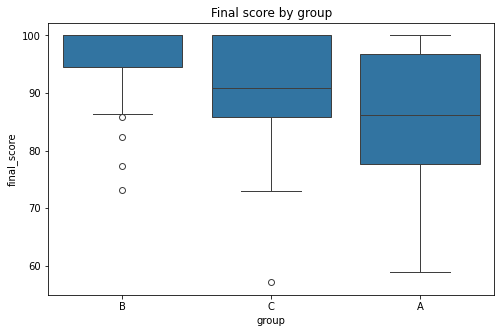

In [7]:
# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x='group', y='final_score', data=df)
plt.title('Final score by group')
plt.show()

In [8]:
# ANOVA
model = ols('final_score ~ C(group)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('ANOVA table:')
print(anova_table)

ANOVA table:
                sum_sq     df          F        PR(>F)
C(group)   3455.189892    2.0  19.879499  1.628012e-08
Residual  15381.892052  177.0        NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B  10.6248    0.0  6.6265 14.6232   True
     A      C   5.2612 0.0052   1.327  9.1953   True
     B      C  -5.3637 0.0093 -9.6255 -1.1018   True
----------------------------------------------------


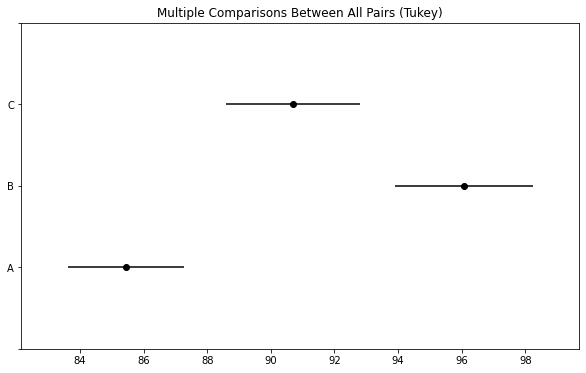

In [10]:
# итоговое понимание: пост-хок Tukey HSD, если p < 0.05 (связь есть)
tukey = pairwise_tukeyhsd(endog=df['final_score'], groups=df['group'], alpha=0.05)
print(tukey)

tukey.plot_simultaneous()
plt.show()

## 3. Корреляционный анализ и корреляция Пирсона

**Задача:** Постройте корреляционную матрицу для числовых переменных (`study_hours`, `attendance`, `midterm_score`, `final_score`, `motivation`, `age`).  

**Задача:** Для пары `study_hours` — `final_score` проведите тест на значимость корреляции Пирсона и интерпретируйте.

,study_hours,attendance,midterm_score,final_score,motivation,age
study_hours,1.000000,0.698592,0.765000,0.744716,0.600922,0.051004
attendance,0.698592,1.000000,0.642359,0.605286,0.415886,-0.013544
midterm_score,0.765000,0.642359,1.000000,0.725896,0.505147,-0.022407
final_score,0.744716,0.605286,0.725896,1.000000,0.436890,-0.017267
motivation,0.600922,0.415886,0.505147,0.436890,1.000000,0.106087
age,0.051004,-0.013544,-0.022407,-0.017267,0.106087,1.000000


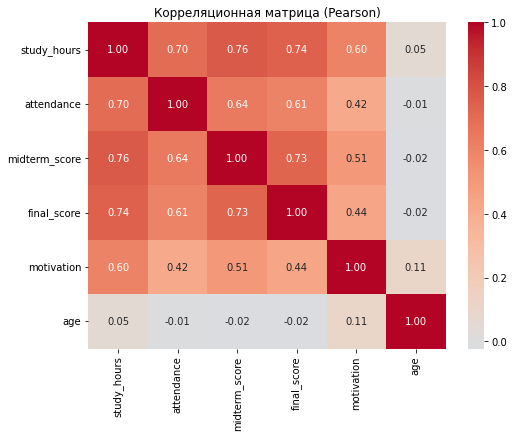

In [11]:
# корреляционная матрица из pandas
num_cols = ['study_hours','attendance','midterm_score','final_score','motivation','age']
corr = df[num_cols].corr()
display(corr)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляционная матрица (Pearson)')
plt.show()

In [12]:
# pearson test: study_hours vs final_score
r, p = pearsonr(df['study_hours'], df['final_score'])
print(f'Pearson r = {r:.3f}, p-value = {p:.3e}')

Pearson r = 0.745, p-value = 4.374e-33


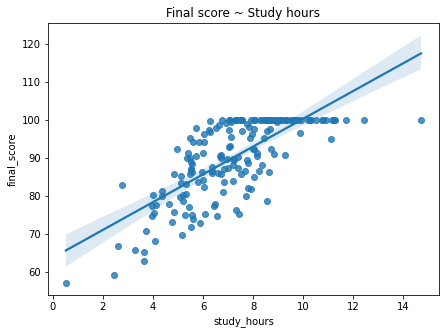

In [13]:
# график рассеяния + линия регрессии
plt.figure(figsize=(7,5))
sns.regplot(x='study_hours', y='final_score', data=df, ci=95)
plt.title('Final score ~ Study hours')
plt.show()

## 4. Корреляция Спирмена

**Задача** Посчитайте корреляцию Спирмена между переменными `motivation` и `final_score`.  
Интерпретируйте разницу между результатами Спирмена и Пирсона.

,study_hours,attendance,midterm_score,final_score,motivation,age
study_hours,1.000000,0.683202,0.754673,0.767677,0.590400,0.045623
attendance,0.683202,1.000000,0.625145,0.579280,0.424259,-0.015743
midterm_score,0.754673,0.625145,1.000000,0.746838,0.506847,-0.033354
final_score,0.767677,0.579280,0.746838,1.000000,0.462560,0.002634
motivation,0.590400,0.424259,0.506847,0.462560,1.000000,0.108965
age,0.045623,-0.015743,-0.033354,0.002634,0.108965,1.000000


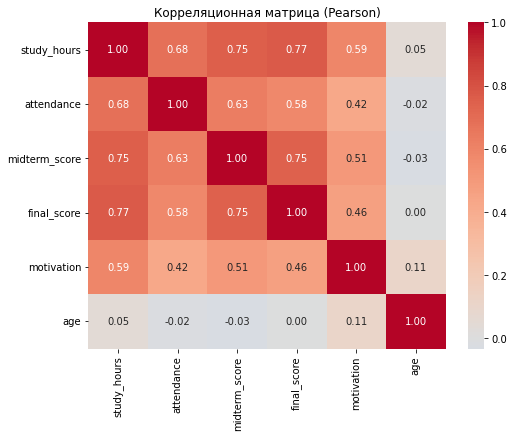

In [14]:
# корреляционная матрица из pandas
num_cols = ['study_hours','attendance','midterm_score','final_score','motivation','age']
corr = df[num_cols].corr(method='spearman')
display(corr)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляционная матрица (Pearson)')
plt.show()

In [15]:
# spearman correlation
rho, pval = spearmanr(df['motivation'], df['final_score'])
print(f"Spearman rho = {rho:.3f}, p-value = {pval:.3e}")

# cравним с pearson между motivation и final_score
r, p = pearsonr(df['motivation'], df['final_score'])
print(f"Pearson r = {r:.3f}, p-value = {p:.3e}")

Spearman rho = 0.463, p-value = 6.266e-11
Pearson r = 0.437, p-value = 8.701e-10


## 5. Регрессионный анализ и парная линейная регрессия

**Задача:** Постройте простую линейную регрессию `final_score ~ study_hours`.  
- Оцените коэффициенты, интерпретируйте их.  
- Постройте график остатков и проверьте основные допущения (линейность, нормальность остатков, гомоскедастичность).

In [16]:
# простая линейная регрессия final_score ~ study_hours
model_simple = smf.ols('final_score ~ study_hours', data=df).fit()
print(model_simple.summary())

                            OLS Regression Results                            
Dep. Variable:            final_score   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     221.6
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           4.37e-33
Time:                        18:00:01   Log-Likelihood:                -601.17
No. Observations:                 180   AIC:                             1206.
Df Residuals:                     178   BIC:                             1213.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      63.6512      1.850     34.405      

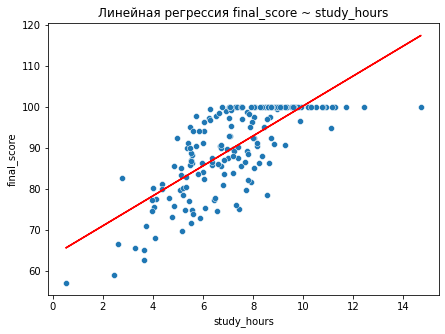

In [17]:
# график: fitted vs observed
plt.figure(figsize=(7,5))
sns.scatterplot(x='study_hours', y='final_score', data=df)
plt.plot(df['study_hours'], model_simple.fittedvalues, color='red')
plt.title('Линейная регрессия final_score ~ study_hours')
plt.show()

In [18]:
# остатки
resid = model_simple.resid
fitted = model_simple.fittedvalues

In [19]:
fitted

0      87.171030
1      86.914982
2      95.218256
3      83.915562
4      89.073102
         ...    
175    95.474304
176    95.291413
177    98.876086
178    98.802929
179    87.573392
Length: 180, dtype: float64

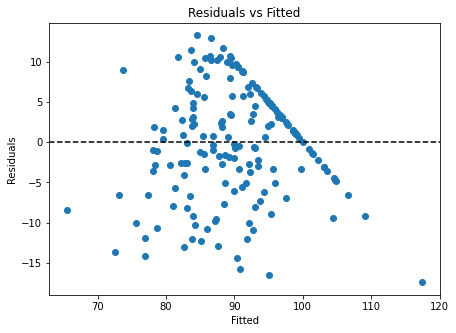

In [20]:
# график остатков vs fitted
plt.figure(figsize=(7,5))
plt.scatter(fitted, resid)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

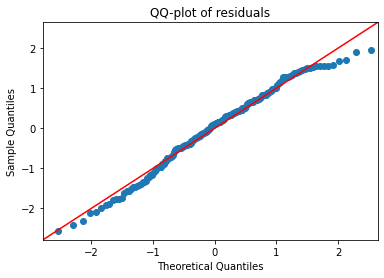

In [21]:
# QQ-plot для остатков
sm.qqplot(resid, line='45', fit=True)
plt.title('QQ-plot of residuals')
plt.show()

## 6. Множественная линейная регрессия

**Задача:** Постройте множественную регрессию `final_score` на предикторы: `study_hours`, `attendance`, `motivation`, `age`, `gender` (закодировать), `midterm_score`.  
- Оцените важность предикторов, проверьте мультиколлинеарность (VIF).  
- Выполните небольшой отбор признаков (например, вручную удалите слабые и повторно оцените модель).

In [22]:
# кодирование пола
df['gender_M'] = (df['gender']=='M').astype(int)

# модель с несколькими предикторами
formula = 'final_score ~ study_hours + attendance + motivation + age + gender_M + midterm_score'
model_multi = smf.ols(formula, data=df).fit()
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:            final_score   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     46.90
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           7.96e-34
Time:                        18:00:02   Log-Likelihood:                -587.05
No. Observations:                 180   AIC:                             1188.
Df Residuals:                     173   BIC:                             1210.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        44.3224      6.314      7.019

In [23]:
# VIF
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('\nVIF:')
print(vif_data)


VIF:
         feature         VIF
0      Intercept  173.129302
1    study_hours    3.440054
2     attendance    2.079268
3     motivation    1.597399
4            age    1.039399
5       gender_M    1.027351
6  midterm_score    2.598151


In [27]:
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
0,Intercept,173.129302
1,study_hours,3.440054
6,midterm_score,2.598151
2,attendance,2.079268
3,motivation,1.597399
4,age,1.039399
5,gender_M,1.027351


In [28]:
# ручной отбор - убираем 'age' если он незначим и смотрим, как изменится модель
model_reduced = smf.ols('final_score ~ study_hours + attendance + motivation + gender_M + midterm_score', data=df).fit()
print('\nReduced model summary:')
print(model_reduced.summary())


Reduced model summary:
                            OLS Regression Results                            
Dep. Variable:            final_score   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     56.44
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           1.17e-34
Time:                        18:01:41   Log-Likelihood:                -587.22
No. Observations:                 180   AIC:                             1186.
Df Residuals:                     174   BIC:                             1206.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.30